In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

now = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time()))
print("import OK at ", now)
data_path = r"C:\Users\jiant\Desktop\data\motion_controller\IMU&ShoePad"
class_name = ["forward", "stand"]

# IMU 300 Hz
# shoePad 100 Hz

import OK at  2022-09-26 15:29:41


vis data with random start index (plot can vary each run) =  118


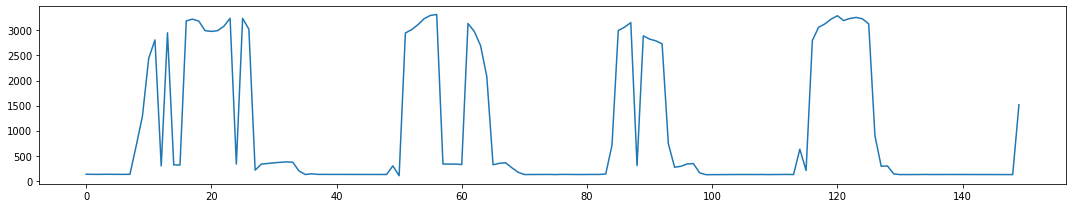

In [18]:
# vis data
sample_data_class_0 = os.listdir(os.path.join(data_path, class_name[0]))[0]
sample_data_class_1 = os.listdir(os.path.join(data_path, class_name[0]))[0]
sample_data_class_2 = os.listdir(os.path.join(data_path, class_name[0]))[0]

plt.rcParams['figure.figsize'] = (15,3)  # 单位是inches
fig, axs = plt.subplots(1, 1)

random_start = random.randint(0, 200)
print("vis data with random start index (plot can vary each run) = ", random_start)

with open(os.path.join(os.path.join(data_path, class_name[0]), sample_data_class_0)) as f:
    logs = f.read().split('\n')
    f1 = [int(i.split(",")[0]) for i in logs if i != '']
    f2 = [int(i.split(",")[1]) for i in logs if i != '']
    f3 = [int(i.split(",")[2]) for i in logs if i != '']
    f4 = [int(i.split(",")[3]) for i in logs if i != '']
    f5 = [int(i.split(",")[4]) for i in logs if i != '']
    f6 = [int(i.split(",")[5]) for i in logs if i != '']
    f7 = [int(i.split(",")[6]) for i in logs if i != '']
    f8 = [int(i.split(",")[7]) for i in logs if i != '']
# axs.plot(f1[random_start:random_start + 100])
# axs.plot(f2[random_start:random_start + 100])
# axs.plot(f3[random_start:random_start + 100])
axs.plot(f4[random_start:random_start + 150])
# axs.plot(f5[random_start:random_start + 100])
# axs.plot(f6[random_start:random_start + 100])
# axs.plot(f7[random_start:random_start + 100])
# axs.plot(f8[random_start:random_start + 100])
fig.tight_layout()
# plt.show()

vis data with random start index (plot can vary each run) =  142


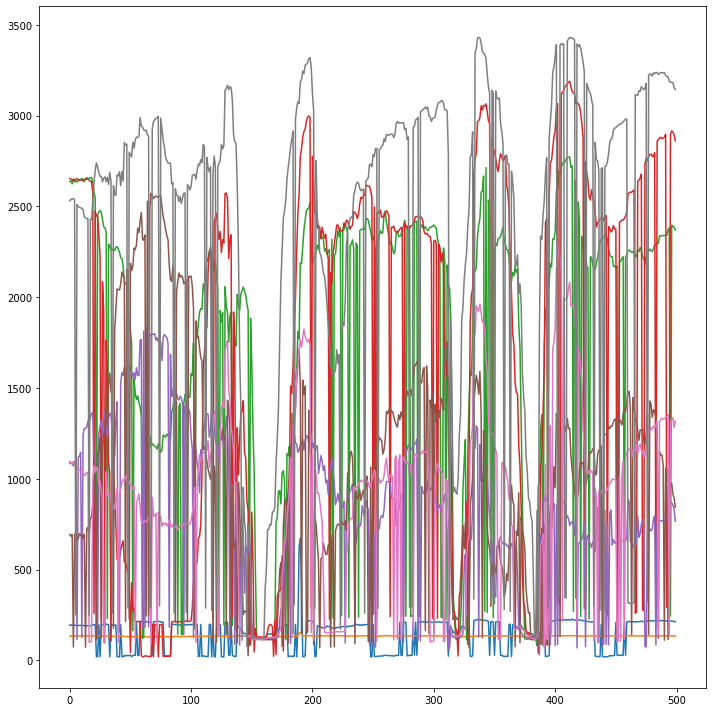

In [3]:
# vis data
sample_data_class_0 = os.listdir(os.path.join(data_path, class_name[1]))[0]
sample_data_class_1 = os.listdir(os.path.join(data_path, class_name[1]))[0]
sample_data_class_2 = os.listdir(os.path.join(data_path, class_name[1]))[0]

plt.rcParams['figure.figsize'] = (10.0, 10.0)  # 单位是inches
fig, axs = plt.subplots(1, 1)

random_start = random.randint(0, 200)
print("vis data with random start index (plot can vary each run) = ", random_start)

with open(os.path.join(os.path.join(data_path, class_name[1]), sample_data_class_0)) as f:
    logs = f.read().split('\n')
    f1 = [int(i.split(",")[0]) for i in logs if i != '']
    f2 = [int(i.split(",")[1]) for i in logs if i != '']
    f3 = [int(i.split(",")[2]) for i in logs if i != '']
    f4 = [int(i.split(",")[3]) for i in logs if i != '']
    f5 = [int(i.split(",")[4]) for i in logs if i != '']
    f6 = [int(i.split(",")[5]) for i in logs if i != '']
    f7 = [int(i.split(",")[6]) for i in logs if i != '']
    f8 = [int(i.split(",")[7]) for i in logs if i != '']
axs.plot(f1[random_start:random_start + 500])
axs.plot(f2[random_start:random_start + 500])
axs.plot(f3[random_start:random_start + 500])
axs.plot(f4[random_start:random_start + 500])
axs.plot(f5[random_start:random_start + 500])
axs.plot(f6[random_start:random_start + 500])
axs.plot(f7[random_start:random_start + 500])
axs.plot(f8[random_start:random_start + 500])
fig.tight_layout()
# plt.show()

In [4]:
# build dataset
# 50 Hz 下,实测采集1s数据约有30个点，故取30为数据长度
# sensor dim = 8+12=20 , 数据scale区别很大 需要归一化

data_length = 30  #
random_lag_min = 0
random_lag_max = 30
repeat_times = 1  # 每组数据重复随机采样次数
# random_lag = random.randint(0, 60)

In [5]:
data_class_0 = []
files_data_class = os.listdir(os.path.join(data_path, class_name[0]))
current_index = 0
for file in files_data_class:
    with open(os.path.join(os.path.join(data_path, class_name[0]), file)) as f:
        logs = f.read().split('\n')
        f1 = [int(i.split(",")[0]) for i in logs if i != '']
        f2 = [int(i.split(",")[1]) for i in logs if i != '']
        f3 = [int(i.split(",")[2]) for i in logs if i != '']
        f4 = [int(i.split(",")[3]) for i in logs if i != '']
        f5 = [int(i.split(",")[4]) for i in logs if i != '']
        f6 = [int(i.split(",")[5]) for i in logs if i != '']
        f7 = [int(i.split(",")[6]) for i in logs if i != '']
        f8 = [int(i.split(",")[7]) for i in logs if i != '']
    i_data_class = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8])  # shape = (8+12)*N
    print("loading file :", file)
    # print(i_data_class)
    print(i_data_class.shape)
    print(i_data_class.shape[1])
    for r_i in range(repeat_times):
        current_index = 0  # 重置
        i_max_loop = i_data_class.shape[1] // data_length
        for i in range(i_max_loop):
            random_lag = random.randint(random_lag_min, random_lag_max)  # 给一个随机lag,模拟推理阶段的随机取数
            current_index = current_index + random_lag
            tmp_start_index = current_index
            tmp_end_index = current_index + data_length
            current_index = tmp_end_index
            if tmp_end_index < i_data_class.shape[1]:
                print(f"append with {tmp_start_index} to {tmp_end_index}")
                data_class_0.append(i_data_class[:, tmp_start_index:tmp_end_index])

print("............检查数据准确性............")
print(f"理论构建的classes 的数据总量 约等于 txt文件数*每个文件行数/data_length/(mean(random_lag_min,random_lag_max))")
print(f"实际构建的classes 的数据总量 = {len(data_class_0)},")
print(f"以下是第1个数据，,请核对txt检查")
print(data_class_0[0])
print(f"以下是第2个数据，,请核对txt检查")
print(data_class_0[1])

loading file : 0826_f_1.txt
(8, 5000)
5000
append with 18 to 48
append with 57 to 87
append with 107 to 137
append with 159 to 189
append with 200 to 230
append with 244 to 274
append with 276 to 306
append with 322 to 352
append with 370 to 400
append with 401 to 431
append with 438 to 468
append with 497 to 527
append with 556 to 586
append with 603 to 633
append with 648 to 678
append with 686 to 716
append with 727 to 757
append with 778 to 808
append with 814 to 844
append with 862 to 892
append with 899 to 929
append with 940 to 970
append with 972 to 1002
append with 1016 to 1046
append with 1075 to 1105
append with 1123 to 1153
append with 1183 to 1213
append with 1238 to 1268
append with 1288 to 1318
append with 1331 to 1361
append with 1378 to 1408
append with 1419 to 1449
append with 1453 to 1483
append with 1498 to 1528
append with 1529 to 1559
append with 1579 to 1609
append with 1630 to 1660
append with 1663 to 1693
append with 1707 to 1737
append with 1754 to 1784
append

In [6]:
data_class_1 = []
files_data_class = os.listdir(os.path.join(data_path, class_name[1]))
current_index = 0
for file in files_data_class:
    with open(os.path.join(os.path.join(data_path, class_name[1]), file)) as f:
        logs = f.read().split('\n')
        f1 = [int(i.split(",")[0]) for i in logs if i != '']
        f2 = [int(i.split(",")[1]) for i in logs if i != '']
        f3 = [int(i.split(",")[2]) for i in logs if i != '']
        f4 = [int(i.split(",")[3]) for i in logs if i != '']
        f5 = [int(i.split(",")[4]) for i in logs if i != '']
        f6 = [int(i.split(",")[5]) for i in logs if i != '']
        f7 = [int(i.split(",")[6]) for i in logs if i != '']
        f8 = [int(i.split(",")[7]) for i in logs if i != '']
    i_data_class = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8])  # shape = (8+12)*N
    print("loading file :", file)
    # print(i_data_class)
    print(i_data_class.shape)
    print(i_data_class.shape[1])
    for r_i in range(repeat_times):
        current_index = 0  # 重置
        i_max_loop = i_data_class.shape[1] // data_length
        for i in range(i_max_loop):
            random_lag = random.randint(random_lag_min, random_lag_max)  # 给一个随机lag,模拟推理阶段的随机取数
            current_index = current_index + random_lag
            tmp_start_index = current_index
            tmp_end_index = current_index + data_length
            current_index = tmp_end_index
            if tmp_end_index < i_data_class.shape[1]:
                print(f"append with {tmp_start_index} to {tmp_end_index}")
                data_class_1.append(i_data_class[:, tmp_start_index:tmp_end_index])

print("............检查数据准确性............")
print(f"理论构建的classes 的数据总量 约等于 txt文件数*每个文件行数/data_length/(mean(random_lag_min,random_lag_max))")
print(f"实际构建的classes 的数据总量 = {len(data_class_1)},")
print(f"以下是第1个数据，,请核对txt检查")
print(data_class_1[0])
print(f"以下是第2个数据，,请核对txt检查")
print(data_class_1[1])

loading file : 0826_stand_1.txt
(8, 5000)
5000
append with 0 to 30
append with 47 to 77
append with 101 to 131
append with 157 to 187
append with 200 to 230
append with 232 to 262
append with 279 to 309
append with 323 to 353
append with 363 to 393
append with 415 to 445
append with 469 to 499
append with 528 to 558
append with 582 to 612
append with 637 to 667
append with 679 to 709
append with 736 to 766
append with 767 to 797
append with 798 to 828
append with 829 to 859
append with 864 to 894
append with 914 to 944
append with 971 to 1001
append with 1018 to 1048
append with 1057 to 1087
append with 1096 to 1126
append with 1149 to 1179
append with 1205 to 1235
append with 1236 to 1266
append with 1277 to 1307
append with 1312 to 1342
append with 1364 to 1394
append with 1416 to 1446
append with 1472 to 1502
append with 1524 to 1554
append with 1569 to 1599
append with 1618 to 1648
append with 1661 to 1691
append with 1702 to 1732
append with 1744 to 1774
append with 1787 to 1817
a

In [63]:
# data_class_2 = []
# files_data_class = os.listdir(os.path.join(data_path, class_name[2]))
# current_index = 0
# for file in files_data_class:
#     with open(os.path.join(os.path.join(data_path, class_name[2]), file)) as f:
#         logs = f.read().split('\n')
#         f1 = [int(i.split(",")[0]) for i in logs if i != '']
#         f2 = [int(i.split(",")[1]) for i in logs if i != '']
#         f3 = [int(i.split(",")[2]) for i in logs if i != '']
#         f4 = [int(i.split(",")[3]) for i in logs if i != '']
#         f5 = [int(i.split(",")[4]) for i in logs if i != '']
#         f6 = [int(i.split(",")[5]) for i in logs if i != '']
#         f7 = [int(i.split(",")[6]) for i in logs if i != '']
#         f8 = [int(i.split(",")[7]) for i in logs if i != '']
#         f9 = [float(i.split(",")[8]) for i in logs if i != '']  # IMU data , 12 dim
#         f10 = [float(i.split(",")[9]) for i in logs if i != '']
#         f11 = [float(i.split(",")[10]) for i in logs if i != '']
#         f12 = [float(i.split(",")[11]) for i in logs if i != '']
#         f13 = [float(i.split(",")[12]) for i in logs if i != '']
#         f14 = [float(i.split(",")[13]) for i in logs if i != '']
#         f15 = [float(i.split(",")[14]) for i in logs if i != '']
#         f16 = [float(i.split(",")[15]) for i in logs if i != '']
#         f17 = [float(i.split(",")[16]) for i in logs if i != '']
#         f18 = [float(i.split(",")[17]) for i in logs if i != '']
#         f19 = [float(i.split(",")[18]) for i in logs if i != '']
#         f20 = [float(i.split(",")[19]) for i in logs if i != '']
#     i_data_class = np.vstack([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10,
#                               f11, f12, f13, f14, f15, f16, f17, f18, f19, f20])  # shape = (8+12)*N
#     print("loading file :", file)
#     # print(i_data_class)
#     print(i_data_class.shape)
#     print(i_data_class.shape[1])
#     for r_i in range(repeat_times):
#         current_index = 0  # 重置
#         i_max_loop = i_data_class.shape[1] // data_length
#         for i in range(i_max_loop):
#             random_lag = random.randint(random_lag_min, random_lag_max)  # 给一个随机lag,模拟推理阶段的随机取数
#             current_index = current_index + random_lag
#             tmp_start_index = current_index
#             tmp_end_index = current_index + data_length
#             current_index = tmp_end_index
#             if tmp_end_index < i_data_class.shape[1]:
#                 print(f"append with {tmp_start_index} to {tmp_end_index}")
#                 data_class_2.append(i_data_class[:, tmp_start_index:tmp_end_index])
#
# print("............检查数据准确性............")
# print(f"理论构建的classes 的数据总量 约等于 txt文件数*每个文件行数/data_length/(mean(random_lag_min,random_lag_max))")
# print(f"实际构建的classes 的数据总量 = {len(data_class_2)},")
# print(f"以下是第1个数据，,请核对txt检查")
# print(data_class_2[0])
# print(f"以下是第2个数据，,请核对txt检查")
# print(data_class_2[1])

In [7]:
label_class_0 = [class_name[0] for i in range(len(data_class_0))]  # class name
label_class_1 = [class_name[1] for i in range(len(data_class_1))]
# label_class_2 = [class_name[2] for i in range(len(data_class_2))]
# all_data = data_class_0 + data_class_1 + data_class_2
# all_label = label_class_0 + label_class_1 + label_class_2
all_data = data_class_0 + data_class_1
all_label = label_class_0 + label_class_1

if not len(all_data) == len(all_label):
    raise RuntimeError
print(f"dataset 组合完毕,总数据量为{len(all_data)}")
print(f"dataset 一个例子:shape of model input data (without extend & the batch dim) is {all_data[0].shape}")
# print(f",三个类别的数据量分别为{len(data_class_0)},{len(data_class_1)},{len(data_class_2)}")
print(f",2个类别的数据量分别为{len(data_class_0)},{len(data_class_1)}")

dataset 组合完毕,总数据量为769
dataset 一个例子:shape of model input data (without extend & the batch dim) is (8, 30)
,2个类别的数据量分别为330,439


In [ ]:
# 将每个传感器的数据标准化，使其均值为零，标准差为一。
# 我们通过训练数据集的参数对测试数据集进行规范化
# todo

In [8]:
def random_true(prob):
    p = ([prob, 1 - prob])
    return np.random.choice([True, False], p=p)


class CustomDataset(Dataset):
    def __init__(self, images_, labels_, transform=None):
        self.images = images_
        self.labels = labels_
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx]).type(torch.long)
        return img, label  # img / label shall be tensor or numpy


data_train = []
label_train = []
data_val = []
label_val = []
data_test = []
label_test = []
for i in range(len(all_label)):
    if random_true(0.6):
        data_train.append(all_data[i])
        label_train.append(all_label[i])
    else:
        if random_true(0.5):
            data_val.append(all_data[i])
            label_val.append(all_label[i])
        else:
            data_test.append(all_data[i])
            label_test.append(all_label[i])

# label transfer 2 int
label_train = [class_name.index(i) for i in label_train]
label_val = [class_name.index(i) for i in label_val]
label_test = [class_name.index(i) for i in label_test]

# 8*10 ==> 1*8*10
test_transform = transforms.Compose([
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.ToTensor()
])

print(f"tran val text split finished with length = {len(data_train)},{len(data_val)},{len(data_test)}")

train = CustomDataset(data_train, label_train, train_transform)
val = CustomDataset(data_val, label_val, test_transform)
test = CustomDataset(data_test, label_test, test_transform)

test_bs = 2
train_loader = DataLoader(train, batch_size=test_bs, shuffle=True)
val_loader = DataLoader(val, batch_size=test_bs, shuffle=True)
test_loader = DataLoader(test, batch_size=test_bs, shuffle=True)
print('========reading all img into memory done! ready to --fly--')

for j, (_inputs, _labels) in enumerate(train_loader):
    print(f"checking {j}th data")
    print(_labels.shape)
    print(_inputs.shape)
    print(_labels)
    print(_inputs)
    if j == 5:
        break

tran val text split finished with length = 479,130,160
========reading all img into memory done! ready to --fly--
checking 0th data
torch.Size([2])
torch.Size([2, 1, 8, 30])
tensor([0, 1])
tensor([[[[ 126,  133,  128,  124,  132,  584,  107, 1113, 1074, 1045,  833,
            612,  153,  217,  227,  220,  215,   29,  211,  216,  229,  246,
            250,  251,  252,  248,  240,  239,  236,  239],
          [ 129,  128,  130,  128,  128,  149,  165,  169,  167,  167,  157,
            148,  125,  129,  128,  134,  134,  143,  152,  496, 1539, 2359,
           2698, 2894, 3026, 3281, 3451, 3472,  350,  359],
          [ 125,  130,  130,  140,  132,  130,  130,  132,  129,  124,  116,
            121,  121,  133,  122,   61,  624, 1261, 2181, 2482, 2683,  284,
           2882, 3034, 3072, 3130,  329, 3216, 3177, 3085],
          [ 339,  428,  452,  718,   55,  486,  542,  563,  468,  362,  129,
            259,  247,  530,  477, 1634, 2691, 3018, 3115, 3123, 3156, 3230,
            339

In [10]:
class V1_Backbone(nn.Module):
    def __init__(self):
        super(V1_Backbone, self).__init__()

        self.first_layers = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=(1, 5), stride=1, padding="valid"),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.Conv2d(50, 50, (1, 3), 1, padding="same"),
            nn.BatchNorm2d(50),
            nn.ReLU(),

            # nn.Linear(4608, 50),
            nn.MaxPool2d(1, 2),
            nn.Dropout(p=0.2),

            nn.Conv2d(50, 40, (1, 5), stride=1, padding="valid"),
            nn.ReLU(),
            # nn.BatchNorm2d(40),
            # nn.Linear(4608, 50),
            nn.MaxPool2d(1, 2),
            nn.Dropout(p=0.2),

            nn.Conv2d(40, 20, (1, 3), stride=1, padding="valid"),
            # nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        self.sec_layers = nn.Sequential(
            nn.Linear(120, 60),
            nn.Dropout(p=0.4),
            nn.Linear(60, 30),
            nn.Dropout(p=0.4),
        )

    def forward(self, _input):
        x = self.first_layers(_input)
        x = x.view(x.size()[0], -1)
        x = self.sec_layers(x)
        return x


class V1_Net(V1_Backbone):
    def __init__(self):
        super().__init__()
        self.lin3 = nn.Linear(30, 2)

    def forward(self, inp):
        x = super().forward(inp)
        x = self.lin3(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("summary of network...")
# params最后print出来要除以100万转换为M为单位（论文中常用的格式）
_net = V1_Net().to(device)
summary(_net, (1, 8, 30))

summary of network...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 50, 8, 26]             300
       BatchNorm2d-2            [-1, 50, 8, 26]             100
              ReLU-3            [-1, 50, 8, 26]               0
            Conv2d-4            [-1, 50, 8, 26]           7,550
       BatchNorm2d-5            [-1, 50, 8, 26]             100
              ReLU-6            [-1, 50, 8, 26]               0
         MaxPool2d-7            [-1, 50, 4, 13]               0
           Dropout-8            [-1, 50, 4, 13]               0
            Conv2d-9             [-1, 40, 4, 9]          10,040
             ReLU-10             [-1, 40, 4, 9]               0
        MaxPool2d-11             [-1, 40, 2, 5]               0
          Dropout-12             [-1, 40, 2, 5]               0
           Conv2d-13             [-1, 20, 2, 3]           2,420
             ReLU

In [12]:
def train_CV(net, dataloader, criterion, optimizer, scaler, e):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        # calculate performance metrics
        loss_tr += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    #print(f"loss on train set at epoch {e} is {loss}")
    print(f"==>acc on train set at epoch {e} is {round(acc, 5)} %")
    return acc, loss


def val_CV(net, dataloader, criterion, e):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    #print(f"loss on val set at epoch {e} is {loss}")
    print(f"====>acc on val set at epoch {e} is {round(acc, 5)} %")
    return acc, loss, e


def test_CV(net, dataloader, e):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)
    acc = 100 * correct_count / n_samples
    print(f"=========>acc on test set at epoch {e} is {round(acc, 5)} %")
    return acc


def save(net, path):
    checkpoint = {
        'params': net.state_dict()
    }
    # save checkpoint
    torch.save(checkpoint, path)


def start_train():
    model = V1_Net
    net = model().to(device)
    scaler = GradScaler()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()

    print('============================ training start ==================================')
    max_epoch = 200
    save_freq = 300  # if >max_epoch不会存 checkpoint

    best_acc = 0.0
    for epoch in range(max_epoch):
        _acc_tr, _loss_tr = train_CV(net, train_loader, criterion, optimizer, scaler, epoch)
        _acc_v, _loss_v, _ = val_CV(net, val_loader, criterion, epoch)
        scheduler.step(_acc_v)
        # save when _acc_v is better
        if _acc_v > best_acc and epoch >= 80:  # 节约时间,前几轮不存
            _acc_t = test_CV(net, test_loader, epoch)
            print(f'a better val acc found, so save check point, epoch is {epoch}')
            best_acc = _acc_v
            pkl_name = str(epoch) + "_best.pkl"
            path = os.path.join(r'../materials', pkl_name)
            torch.save(net, path)
        # save when at point
        if (epoch + 1) % save_freq == 0:
            print(f'just save check point at epoch {epoch}')
            pkl_name = str(epoch) + ".pkl"
            path = os.path.join(r'../materials', pkl_name)
            torch.save(net, path)


start_train()

============================ training start ==================================
==>acc on train set at epoch 0 is 58.66388 %
====>acc on val set at epoch 0 is 50.0 %
==>acc on train set at epoch 1 is 59.29019 %
====>acc on val set at epoch 1 is 53.07692 %
==>acc on train set at epoch 2 is 70.77244 %
====>acc on val set at epoch 2 is 76.15385 %
==>acc on train set at epoch 3 is 81.41962 %
====>acc on val set at epoch 3 is 76.92308 %
==>acc on train set at epoch 4 is 82.881 %
====>acc on val set at epoch 4 is 79.23077 %
==>acc on train set at epoch 5 is 81.83716 %
====>acc on val set at epoch 5 is 82.30769 %
==>acc on train set at epoch 6 is 86.01253 %
====>acc on val set at epoch 6 is 82.30769 %
==>acc on train set at epoch 7 is 86.43006 %
====>acc on val set at epoch 7 is 85.38462 %
==>acc on train set at epoch 8 is 87.68267 %
====>acc on val set at epoch 8 is 90.0 %
==>acc on train set at epoch 9 is 90.39666 %
====>acc on val set at epoch 9 is 89.23077 %
==>acc on train set at epoch 10